In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from pandas.plotting import register_matplotlib_converters
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv(r'C:\Users\Mohamed Fawzi\OneDrive\Área de Trabalho\Stock Price Analysis\Stock Prices Data Set.csv')

df.head()

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


## Preparing & Cleaning Data:

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497472 entries, 0 to 497471
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  497472 non-null  object 
 1   date    497472 non-null  object 
 2   open    497461 non-null  float64
 3   high    497464 non-null  float64
 4   low     497464 non-null  float64
 5   close   497472 non-null  float64
 6   volume  497472 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 26.6+ MB


In [200]:
# Statistics of the dataset
df.describe()

,open,high,low,close,volume
count,497461.000000,497464.000000,497464.000000,497472.000000,4.974720e+05
mean,86.352275,87.132562,85.552467,86.369082,4.253611e+06
std,101.471228,102.312062,100.570957,101.472407,8.232139e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,41.690000,42.090000,41.280000,41.703750,1.080166e+06
50%,64.970000,65.560000,64.353700,64.980000,2.084896e+06
75%,98.410000,99.230000,97.580000,98.420000,4.271928e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [201]:
#checking for null values
df.isnull().sum()

symbol     0
date       0
open      11
high       8
low        8
close      0
volume     0
dtype: int64

In [202]:
# filling null values with previous values
df.fillna(method='ffill', inplace=True)

In [203]:
# convert the 'Date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497472 entries, 0 to 497471
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   symbol  497472 non-null  object        
 1   date    497472 non-null  datetime64[ns]
 2   open    497472 non-null  float64       
 3   high    497472 non-null  float64       
 4   low     497472 non-null  float64       
 5   close   497472 non-null  float64       
 6   volume  497472 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 26.6+ MB


## Exploratory Data Analysis (EDA):

In [205]:
# top 5 symbols by volume
top_5_symbols = df.groupby('symbol')['volume'].sum().nlargest(5).index.tolist()
top_5_symbols

['BAC', 'AAPL', 'GE', 'AMD', 'F']

In [206]:
# mapping symbols to their respective full names
symbol_name = {
    'BAC': 'Bank of America',
    'AAPL': 'Apple Inc.',
    'GE': 'General Electric',
    'AMD': 'Advanced Micro Devices',
    'F': 'Ford Motor Company',
    
}

df['company name'] = df['symbol'].map(symbol_name)


In [207]:
# the top 10 symbols by volume
top_5_companies = df.groupby('company name')['volume'].sum().nlargest(10).reset_index()
top_5_companies

,company name,volume
0,Bank of America,89988444028
1,Apple Inc.,45485758169
2,General Electric,41734050117
3,Advanced Micro Devices,33522535638
4,Ford Motor Company,33144701045


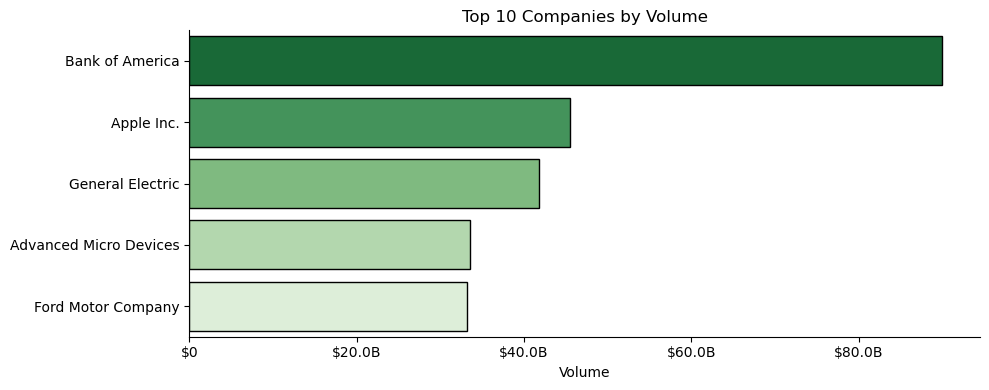

In [208]:
plt.figure(figsize=(10, 4))
sns.barplot(
    data=top_5_companies,
    y='company name',
    x='volume',
    palette='Greens_r',
    edgecolor='black',    
)

def currency(x, pos):
    if x >= 1e9:
        return f'${x*1e-9:.1f}B'
    elif x >= 1e6:
        return f'${x*1e-6:.1f}M'
    elif x >= 1e3:
        return f'${x*1e-3:.1f}K'
    else:
        return f'${x:.0f}'

plt.gca().xaxis.set_major_formatter(FuncFormatter(currency))

plt.title('Top 10 Companies by Volume')
plt.xlabel('Volume')
plt.ylabel('')



sns.despine()
plt.tight_layout()
plt.show()

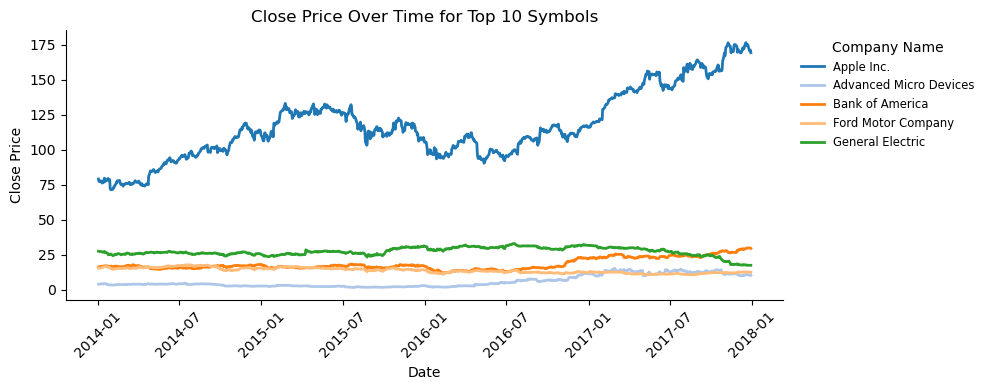

In [209]:
top_5_symbols_list = top_5_companies['company name'].tolist()
df_top_5_symbols = df[df['company name'].isin(top_5_symbols_list)]

plt.figure(figsize=(10, 4))
sns.lineplot(
    data=df_top_5_symbols,
    x='date',
    y='close',
    hue='company name',
    palette='tab20',
    linewidth=2,
)

plt.title('Close Price Over Time for Top 10 Symbols')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Symbol', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.legend(title='Company Name', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False, fontsize='small')

sns.despine()
plt.tight_layout()
plt.show()

In [210]:
df_companies = df[df['symbol'].isin(top_5_symbols)]
df_companies = df_companies.sort_values(by='date')
df_companies

,symbol,date,open,high,low,close,volume,company name
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957,Apple Inc.
31,AMD,2014-01-02,3.8500,3.9800,3.8400,3.9500,20569754,Advanced Micro Devices
58,BAC,2014-01-02,15.6900,16.1600,15.6800,16.1000,149225696,Bank of America
189,F,2014-01-02,15.4200,15.4500,15.2800,15.4400,31544161,Ford Motor Company
191,GE,2014-01-02,27.8600,27.9400,27.4100,27.5000,41503781,General Electric
...,...,...,...,...,...,...,...,...
497026,BAC,2017-12-29,29.8500,29.8800,29.5200,29.5200,40672012,Bank of America
497165,F,2017-12-29,12.5800,12.6100,12.4900,12.4900,18362455,Ford Motor Company
496968,AAPL,2017-12-29,170.5200,170.5900,169.2200,169.2300,25999922,Apple Inc.
496998,AMD,2017-12-29,10.5700,10.5800,10.2700,10.2800,26678928,Advanced Micro Devices


### Moving Average:

In [211]:
short_window = 50
long_window = 200

df_companies.copy().set_index('date', inplace=True)
unique_compnies = df_companies['company name'].unique()


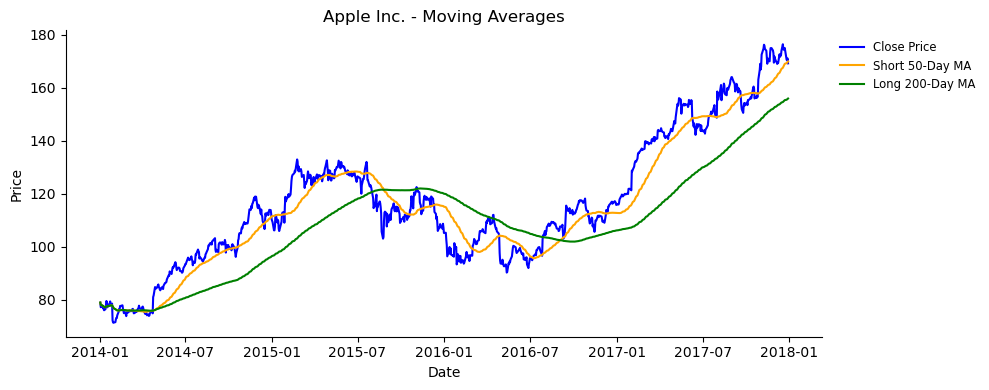

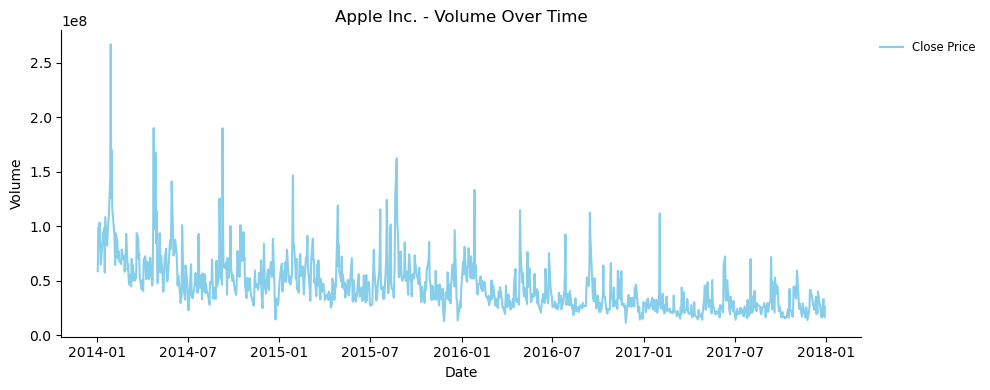

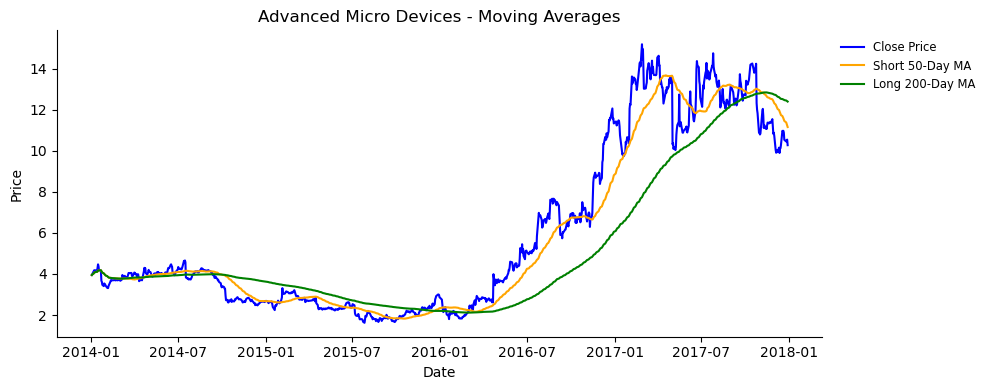

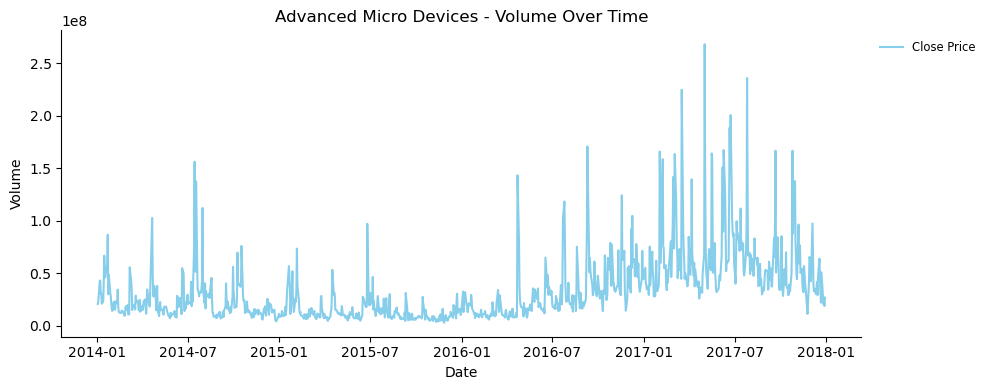

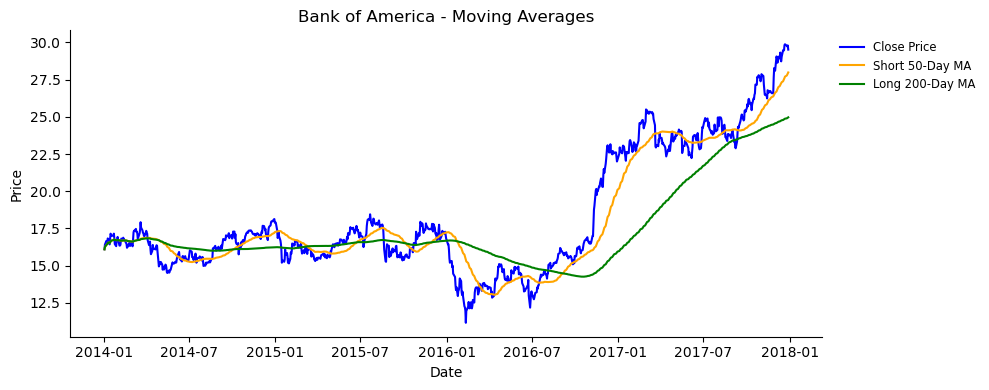

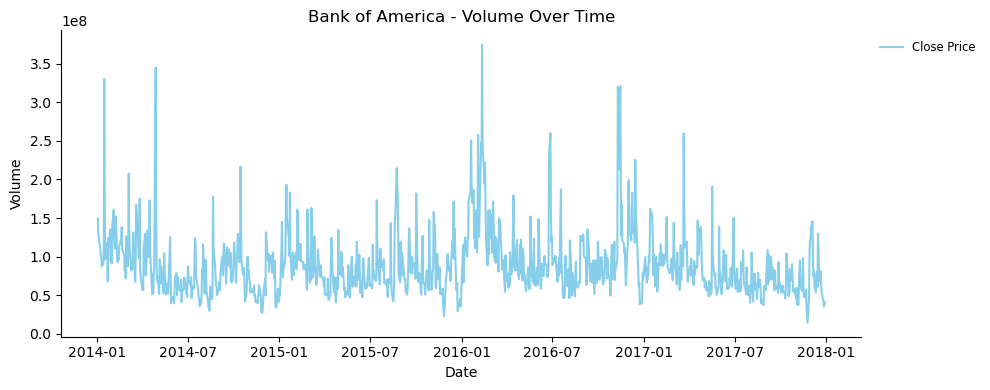

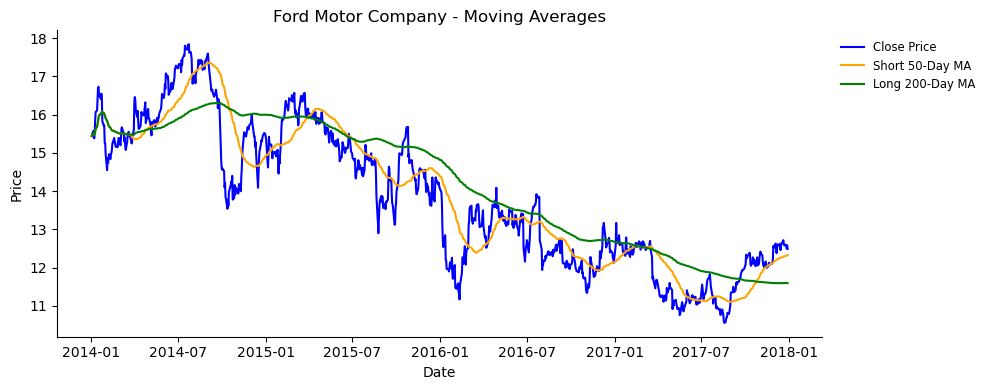

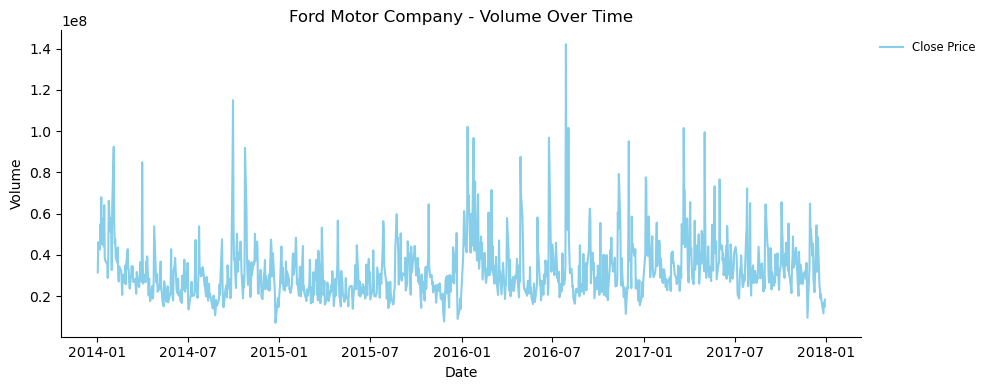

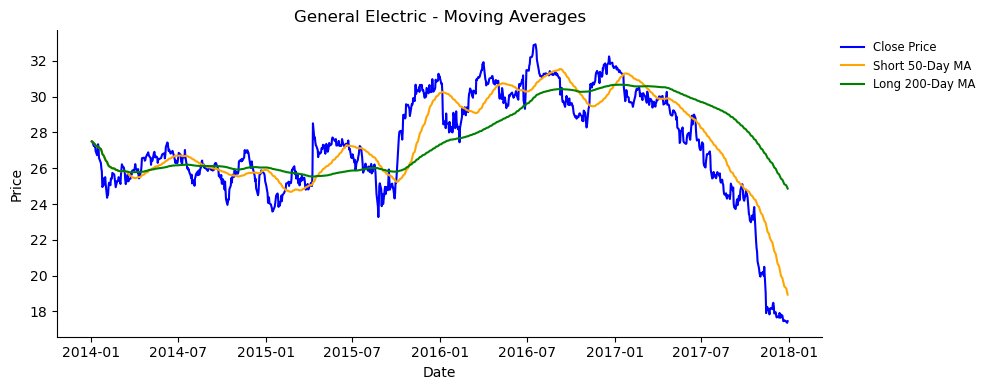

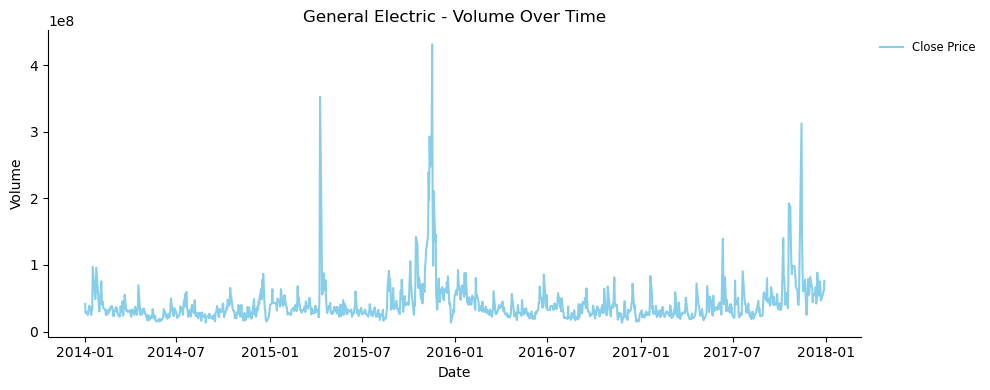

In [212]:
for company in unique_compnies:
    company_data = df_companies[df_companies['company name'] == company]
    company_data['short_mavg'] = company_data['close'].rolling(window=short_window, min_periods=1).mean()
    company_data['long_mavg'] = company_data['close'].rolling(window=long_window, min_periods=1).mean()   
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=company_data, x='date', y='close', label='Close Price', color='blue')
    sns.lineplot(data=company_data, x='date', y='short_mavg', label=f'Short {short_window}-Day MA', color='orange')
    sns.lineplot(data=company_data, x='date', y='long_mavg', label=f'Long {long_window}-Day MA', color='green')
    
    plt.title(f'{company} - Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False, fontsize='small')
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=company_data, x='date', y='volume', label='Close Price', color='skyblue')
    plt.title(f'{company} - Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False, fontsize='small')
    sns.despine()
    plt.tight_layout()
    plt.show()
    
   



### Dialy Return

In [217]:
df_companies['daily_return'] = df_companies.groupby('company name')['close'].pct_change()


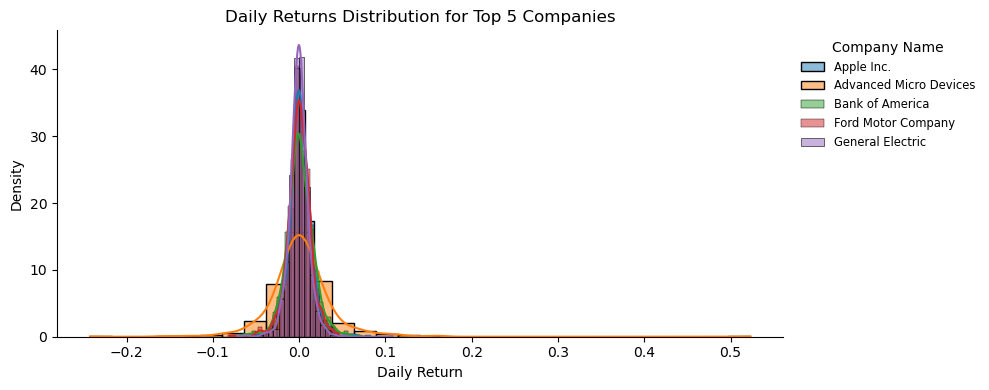

In [218]:
plt.figure(figsize=(10, 4))
for company in unique_compnies:
    company_data = df_companies[df_companies['company name'] == company]
    sns.histplot(
        data=company_data,
        x='daily_return',
        label=company,
        kde=True,
        stat='density',
        bins=30,
        alpha=0.5
    )
plt.title('Daily Returns Distribution for Top 5 Companies')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend(title='Company Name', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False, fontsize='small')
sns.despine()
plt.tight_layout()
plt.show()

### Correlation:

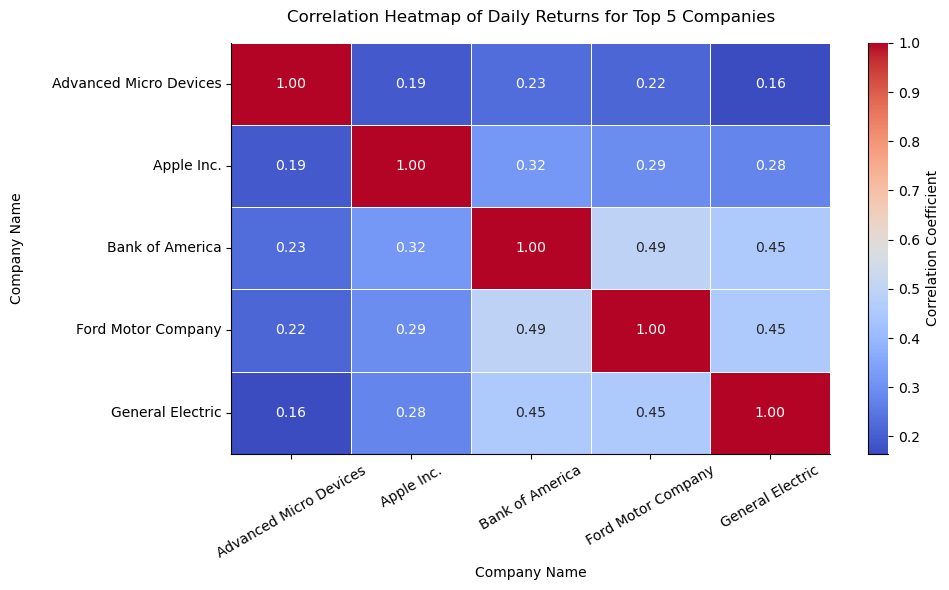

In [224]:
daily_returns = df_companies.pivot_table(
    index='date',
    columns='company name',
    values='daily_return'
)
daily_returns = daily_returns.dropna()

plt.figure(figsize=(10, 6))
sns.heatmap(
    daily_returns.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Heatmap of Daily Returns for Top 5 Companies', pad=15)
plt.xlabel('Company Name')
plt.ylabel('Company Name', labelpad=20)
plt.xticks(rotation=30)
sns.despine()
plt.tight_layout()
plt.show()

### Optimization:

In [226]:
expected_returns = daily_returns.mean() * 252  # annualize the returns
volatility = daily_returns.std() * np.sqrt(252)  # annualize the volatility

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats.round(4)

,Expected Return,Volatility
company name,,
Advanced Micro Devices,0.4245,0.6207
Apple Inc.,0.2166,0.2271
Bank of America,0.1846,0.2558
Ford Motor Company,-0.0288,0.2201
General Electric,-0.0963,0.1881


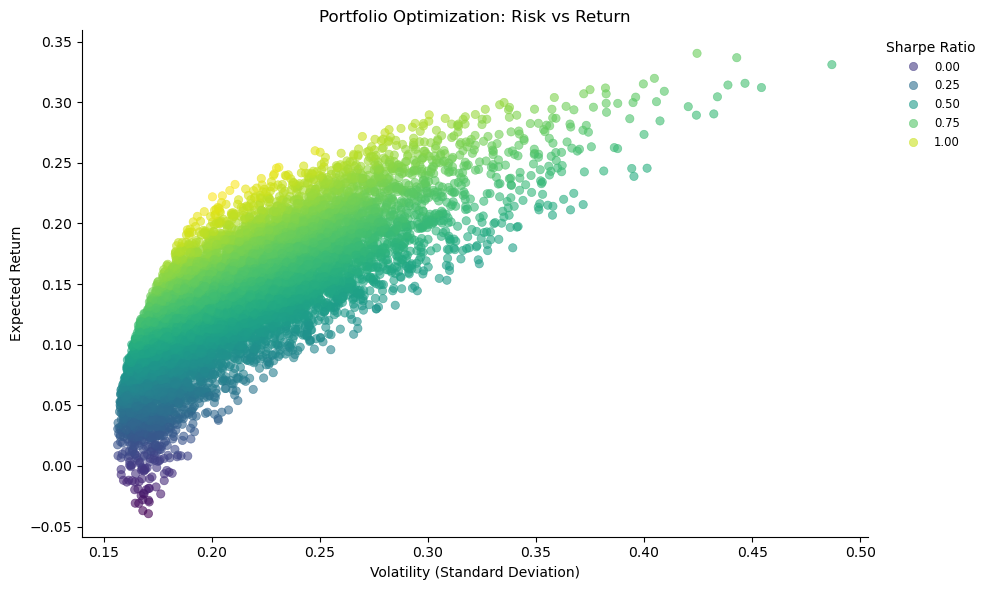

In [ ]:
# function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_compnies))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=results[1,:],
    y=results[0,:],
    hue=results[2,:],
    palette='viridis',
    alpha=0.6,
    edgecolor=None
)

plt.title('Portfolio Optimization: Risk vs Return')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend(title='Sharpe Ratio', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False, fontsize='small')
#plt.grid()
sns.despine()
plt.tight_layout()
plt.show()


In [231]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.2219682245380699, 0.20037189025807617, 1.107781257401814)

In [234]:
max_sharpe_weights = np.zeros(len(unique_compnies))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_compnies))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_compnies,
    'Weight': max_sharpe_weights
})

portfolio_weights_df.round(4)

,Ticker,Weight
0,Apple Inc.,0.1706
1,Advanced Micro Devices,0.2811
2,Bank of America,0.0020
3,Ford Motor Company,0.2636
4,General Electric,0.2827
